## Project Setup & Reproducibility

In [3]:
## Reproducibility Setup

#To ensure that all experiments in this project are fully reproducible, fixed the random seed across Python, NumPy, and the OS hashing environment. 
#This guarantees identical dataset splits and model results across runs.


import os, random
import numpy as np

SEED = 42

os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)

print("Seed fixed:", SEED)

Seed fixed: 42


In [4]:
## Project Directory Structure

#Created a standardized project folder layout to organize processed data, trained models, logs, tables, and figures generated throughout the project.


from pathlib import Path

dirs = [
    "notebooks",
    "src",
    "data",                 # keep out of git
    "outputs",
    "outputs/figures",
    "outputs/tables",
    "outputs/models",
    "outputs/logs",
    "outputs/processed",
]
for d in dirs:
    Path(d).mkdir(parents=True, exist_ok=True)

print("folders created")

folders created


In [115]:
## Version Control Hygiene

# Generated a .gitignore file to ensure large data files and model artifacts are not committed to version control. 
# This keeps the repository lightweight and reproducible.


gitignore = """
# data (keep out of git)
data/
data/**

# common data formats (only under data/)
# (no global ignore for csv/parquet so outputs/tables can be tracked)

# outputs (keep heavy artifacts out)
outputs/processed/
outputs/models/

# notebooks
.ipynb_checkpoints/

# python
__pycache__/
*.pyc
.venv/
.env
.DS_Store
"""
Path(".gitignore").write_text(gitignore.strip() + "\n")
print(".gitignore created")

.gitignore created


In [6]:
## Environment Snapshot

# Exported the current Python environment into `requirements.txt` so the project can be reproduced on another machine.

from pathlib import Path
import subprocess, sys

reqs = subprocess.run(
    [sys.executable, "-m", "pip", "freeze"],
    check=True,
    capture_output=True,
    text=True
).stdout

Path("requirements.txt").write_text(reqs)

print("requirements.txt saved in project root")

requirements.txt saved in project root


## Dataset Loading & Data Quality Checks

In [7]:
## Loading the WildChat Dataset

# oaded the WildChat-1M dataset from HuggingFace and sample a reproducible subset of 100,000 conversations.  
# This subset size provides a balance between computational feasibility and statistical reliability.

from datasets import load_dataset

ds = load_dataset("allenai/WildChat-1M", cache_dir="data/hf_cache")
train = ds["train"]

N = 100_000
train_sub = train.shuffle(seed=SEED).select(range(N))

ds["train"] = train_sub   

print("Full:", len(train), "Sub:", len(ds["train"]))

Full: 837989 Sub: 100000


In [8]:
## Dataset Schema Inspection

# Inspected dataset splits, columns, and feature types to understand the structure before preprocessing.

print("Splits:", list(ds.keys()))
print("Columns:", ds["train"].column_names)
print("Features:\n", ds["train"].features)

Splits: ['train']
Columns: ['conversation_hash', 'model', 'timestamp', 'conversation', 'turn', 'language', 'openai_moderation', 'detoxify_moderation', 'toxic', 'redacted', 'state', 'country', 'hashed_ip', 'header']
Features:
 {'conversation_hash': Value('string'), 'model': Value('string'), 'timestamp': Value('timestamp[us, tz=UTC]'), 'conversation': List({'content': Value('string'), 'country': Value('string'), 'hashed_ip': Value('string'), 'header': {'accept-language': Value('string'), 'user-agent': Value('string')}, 'language': Value('string'), 'redacted': Value('bool'), 'role': Value('string'), 'state': Value('string'), 'timestamp': Value('timestamp[us, tz=UTC]'), 'toxic': Value('bool'), 'turn_identifier': Value('int64')}), 'turn': Value('int64'), 'language': Value('string'), 'openai_moderation': List({'categories': {'harassment': Value('bool'), 'harassment/threatening': Value('bool'), 'harassment_threatening': Value('bool'), 'hate': Value('bool'), 'hate/threatening': Value('bool'), 

In [9]:
## Missing Value Analysis

# Scanned key metadata fields to quantify missing or empty values in the dataset.
# This helps validate dataset quality and detect potential preprocessing issues.

def is_empty(x):
    return x is None or (isinstance(x, str) and x.strip() == "") or (isinstance(x, (list, dict)) and len(x) == 0)

cols_to_check = ["conversation", "turn", "timestamp", "language", "model", "country", "toxic", "redacted"]

counts = {c: 0 for c in cols_to_check}
total = 0

for ex in ds["train"]:
    total += 1
    for c in cols_to_check:
        if is_empty(ex.get(c)):
            counts[c] += 1

print("Total scanned:", total)
for c in cols_to_check:
    print(f"{c:12s} empty={counts[c]:7d} ({counts[c]/total:.3%})")

Total scanned: 100000
conversation empty=      0 (0.000%)
turn         empty=      0 (0.000%)
timestamp    empty=      0 (0.000%)
language     empty=      0 (0.000%)
model        empty=      0 (0.000%)
country      empty=    115 (0.115%)
toxic        empty=      0 (0.000%)
redacted     empty=      0 (0.000%)


In [10]:
## Conversation Structure Validation

# Verified that conversation length aligns with the recorded number of turns (expected ≈ 2 × turns).  
# This ensures structural integrity of the dataset.

def check_turn_alignment(split, max_rows=None):
    bad = []
    scanned = 0
    
    for ex in split:
        scanned += 1
        conv = ex.get("conversation")
        turn = ex.get("turn")
        
        if not isinstance(conv, list) or turn is None:
            bad.append(("invalid_types", ex.get("conversation_hash")))
        else:
            # expected ≈ 2*turn (user+assistant per turn)
            if len(conv) != 2 * int(turn):
                bad.append((f"len(conv)={len(conv)} turn={turn}", ex.get("conversation_hash")))
        
        if max_rows and scanned >= max_rows:
            break
    
    return scanned, bad

scanned, bad = check_turn_alignment(ds["train"], max_rows=None)  # start with 20k
print("Scanned:", scanned)
print("Mismatch count:", len(bad))
print("First 10 mismatches:", bad[:10])

Scanned: 100000
Mismatch count: 0
First 10 mismatches: []


In [11]:
## Moderation Metadata Alignment

# Verified that OpenAI and Detoxify moderation arrays align with conversation length.

def check_alignment(split, max_rows=None):
    issues = []
    scanned = 0
    
    for ex in split:
        scanned += 1
        conv = ex.get("conversation")
        oai = ex.get("openai_moderation")
        detox = ex.get("detoxify_moderation")
        
        if not isinstance(conv, list):
            continue
        
        L = len(conv)
        if isinstance(oai, list) and len(oai) != L:
            issues.append(("openai_len_mismatch", L, len(oai), ex.get("conversation_hash")))
        if isinstance(detox, list) and len(detox) != L:
            issues.append(("detox_len_mismatch", L, len(detox), ex.get("conversation_hash")))
        
        # stop only if user provided a limit
        if max_rows is not None and scanned >= max_rows:
            break
            
    return scanned, issues

In [12]:
## Conversation-Level Dataset Export

# Stored a compact conversation-level dataset for downstream analysis and reproducibility.

scanned, issues = check_alignment(ds["train"], max_rows=None)

print("Scanned:", scanned)
print("Alignment issues:", len(issues))
print("First 10 issues:", issues[:10])

Scanned: 100000
Alignment issues: 0
First 10 issues: []


## Feature Extraction Dataset Creation

In [13]:
## Extracting First User Message

## For both research questions, used the first user message from each conversation as input.

conv_cols = ["conversation_hash", "model", "timestamp", "language", "country", "state", "turn", "toxic", "redacted"]
conv_ds = ds["train"].remove_columns([c for c in ds["train"].column_names if c not in conv_cols])

conv_out = "outputs/processed/conversations.parquet"
conv_ds.to_parquet(conv_out)
print("wrote:", conv_out)

Creating parquet from Arrow format:   0%|          | 0/100 [00:00<?, ?ba/s]

wrote: outputs/processed/conversations.parquet


In [76]:
import warnings
warnings.filterwarnings("ignore")

In [77]:
# First User Text Table
import pandas as pd
from tqdm import tqdm

def extract_first_user_rows(hf_split):
    rows = []
    for ex in tqdm(hf_split, total=len(hf_split)):
        conv = ex.get("conversation") or []
        first_user = ""
        for msg in conv:
            if isinstance(msg, dict) and msg.get("role") == "user":
                first_user = msg.get("content", "") or ""
                break

        t = ex.get("turn")
        try:
            t = int(t) if t is not None else None
        except:
            t = None

        rows.append({
            "conversation_hash": ex.get("conversation_hash"),
            "turn": t,
            "language": ex.get("language") or "unknown",
            "model": ex.get("model") or "unknown",
            "country": ex.get("country"),
            "state": ex.get("state"),
            "first_user_text": first_user
        })
    return pd.DataFrame(rows)

rq_base = extract_first_user_rows(ds["train"])
rq_base = rq_base.dropna(subset=["turn"])   # must have turn for RQ1
rq_base.to_parquet("outputs/processed/rq_base_first_user.parquet", index=False)

print("Saved:", rq_base.shape)
rq_base.head()

100%|█████████████████████████████████| 100000/100000 [00:58<00:00, 1722.55it/s]


Saved: (100000, 7)


,conversation_hash,turn,language,model,country,state,first_user_text
0,3bac6530e8ae0340833ace0871f67fe3,1,English,gpt-3.5-turbo-0613,Australia,New South Wales,\n As a prompt gene...
1,aceb43170c4f4903360888141409916d,1,English,gpt-3.5-turbo-0613,United States,Michigan,[there would be dialogue in this story:]\n\n(E...
2,0cee675ca3dc17974e8f3afaa08d3fb0,1,Turkish,gpt-3.5-turbo-0125,Türkiye,None,You are a Turk. From now on you will answer on...
3,41b529aecbd130a5520308d6379d9d58,3,Russian,gpt-3.5-turbo-0613,Russia,Moscow,Полимерия
4,cdc554d27027c976ac937f0fdd7f0622,1,Nolang,gpt-3.5-turbo-0301,Russia,Omsk Oblast,


In [82]:
## Creating Conversation Length Labels

# Converted the number of turns into categorical buckets:
# - Short (≤2 turns)
# - Medium (3–5 turns)
# - Long (≥6 turns)


import pandas as pd

rq1 = pd.read_parquet("outputs/processed/rq_base_first_user.parquet").copy()

def turn_bucket(t):
    if t <= 2:
        return "short"
    elif 3 <= t <= 5:
        return "medium"
    else:
        return "long"

def make_turn_binary(t):
    # binary label to reduce noise; you can tweak cutoff
    return "long" if t >= 6 else "not_long"

rq1["turn_bucket"] = rq1["turn"].apply(turn_bucket)

print("RQ1 class distribution:")
print(rq1["turn_bucket"].value_counts())
print(rq1["turn_bucket"].value_counts(normalize=True).round(4))

rq1_path = "outputs/processed/rq1_first_user_turn.parquet"
rq1.to_parquet(rq1_path, index=False)
print("Saved:", rq1_path)

RQ1 class distribution:
turn_bucket
short     75375
medium    15841
long       8784
Name: count, dtype: int64
turn_bucket
short     0.7538
medium    0.1584
long      0.0878
Name: proportion, dtype: float64
Saved: outputs/processed/rq1_first_user_turn.parquet


In [83]:
## Shared Split and Evaluation utilities for both the Research Questions (R1, R2)
# Defined reusable functions for:
# - Stratified splitting
# - Evaluation metrics
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import f1_score, confusion_matrix, classification_report, balanced_accuracy_score

def stratified_train_val_test_split(X, y, test_size=0.20, val_size=0.20, seed=42):
    X_trainval, X_test, y_trainval, y_test = train_test_split(
        X, y, test_size=test_size, random_state=seed, stratify=y
    )
    X_train, X_val, y_train, y_val = train_test_split(
        X_trainval, y_trainval, test_size=val_size, random_state=seed, stratify=y_trainval
    )
    return X_train, X_val, X_test, y_train, y_val, y_test

def eval_multiclass_plus(y_true, y_pred, labels, title=""):
    mf1 = f1_score(y_true, y_pred, average="macro")
    bac = balanced_accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred, labels=labels)

    print("\n" + "=" * 70)
    print(title)
    print("Macro F1:", round(mf1, 4))
    print("Balanced Acc:", round(bac, 4))
    print("Confusion matrix (labels order):", labels)
    print(cm)
    print("\nClassification report:\n", classification_report(y_true, y_pred, digits=4))

    # Per class recall summary
    rep = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    recalls = {lbl: rep[lbl]["recall"] for lbl in labels if lbl in rep}
    print("Per-class recall:", {k: round(v, 4) for k, v in recalls.items()})

    return mf1, bac, cm

## Research Question (RQ) 1: Can we predict conversation length from the first user message?

In [91]:
#RQ1 Modeling - End-to-End, explained further with comments

import re

from scipy.stats import loguniform
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import (
    f1_score,
    confusion_matrix,
    classification_report,
    balanced_accuracy_score
)
from sklearn.calibration import CalibratedClassifierCV
import joblib

# Feature engineering 

CODE_REGEX = re.compile(
    r"```|traceback|stack trace|exception|error:|segmentation fault|\bsyntax error\b|\bcompile\b|\bdebug\b",
    re.IGNORECASE
)

BULLET_REGEX = re.compile(
    r"(^\s*[-*]\s+)|(^\s*\d+\s*[\)\.]\s+)", re.MULTILINE
)

STEP_REGEX = re.compile(
    r"\bstep[- ]by[- ]step\b|\bdetailed\b|\bexplain\b|\bwalk me through\b|\bderive\b|\bprove\b",
    re.IGNORECASE
)

QUESTION_REGEX = re.compile(r"\?")

WHITESPACE_REGEX = re.compile(r"\s+")


def add_structural_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Input df must contain:
      - first_user_text
      - language (optional)
      - model (optional)
    Returns a DataFrame with numeric feature columns.
    """
    text = df["first_user_text"].fillna("").astype(str)

    # Basic length signals
    char_len = text.str.len().astype(float)
    word_count = text.apply(lambda s: 0 if not s else len(WHITESPACE_REGEX.split(s.strip()))).astype(float)

    # punctuation / intent-ish signals
    n_qmarks = text.apply(lambda s: len(QUESTION_REGEX.findall(s))).astype(float)
    has_code = text.apply(lambda s: 1.0 if CODE_REGEX.search(s or "") else 0.0)
    has_bullets = text.apply(lambda s: 1.0 if BULLET_REGEX.search(s or "") else 0.0)
    has_step = text.apply(lambda s: 1.0 if STEP_REGEX.search(s or "") else 0.0)

    # Cheap code-token proxy 
    n_semicolons = text.str.count(";").astype(float)
    n_braces = (text.str.count(r"\{") + text.str.count(r"\}")).astype(float)
    n_parens = (text.str.count(r"\(") + text.str.count(r"\)")).astype(float)

    out = pd.DataFrame({
        "char_len": char_len,
        "word_count": word_count,
        "n_qmarks": n_qmarks,
        "has_code": has_code,
        "has_bullets": has_bullets,
        "has_step": has_step,
        "n_semicolons": n_semicolons,
        "n_braces": n_braces,
        "n_parens": n_parens,
    })

    # log scaling for length features (often stabilizes)
    out["log_char_len"] = np.log1p(out["char_len"])
    out["log_word_count"] = np.log1p(out["word_count"])

 

    return out


# transformer wrapper
struct_feat_transformer = FunctionTransformer(add_structural_features, validate=False)


# model pipeline 

def build_preprocessor(feature_set: str):
    """
    feature_set in: text_only, text_lang, text_lang_model
    Adds:
      - TF-IDF on first_user_text
      - Structural numeric features
      - Optional one-hot language/model
    """
    transformers = []

    # TF-IDF
    transformers.append(
        ("text", TfidfVectorizer(), "first_user_text")
    )

    # Structural features (numeric) + scaling (For SVM margin)
    transformers.append(
        ("struct", Pipeline([
            ("structf", struct_feat_transformer),
            ("scaler", StandardScaler(with_mean=False))
        ]), ["first_user_text"])
    )

    if feature_set in ["text_lang", "text_lang_model"]:
        transformers.append(
            ("lang", OneHotEncoder(handle_unknown="ignore"), ["language"])
        )

    if feature_set == "text_lang_model":
        transformers.append(
            ("model", OneHotEncoder(handle_unknown="ignore"), ["model"])
        )

    return ColumnTransformer(transformers=transformers, remainder="drop")

def make_turn_bucket_3(t):
    if t <= 2:
        return "short"
    elif 3 <= t <= 5:
        return "medium"
    else:
        return "long"

def make_turn_bucket_4(t):
    if t <= 2:
        return "short"
    elif 3 <= t <= 4:
        return "medium"
    elif 5 <= t <= 8:
        return "long"
    else:
        return "very_long"

def make_turn_binary(t):
    return "long" if t >= 6 else "not_long"


def fit_rq1_enhanced(
    rq1_path="outputs/processed/rq1_first_user_turn.parquet",
    label_variant="3class",                 
    feature_sets=("text_only", "text_lang", "text_lang_model"),
    n_iter=30,
):
    # Load
    rq1 = pd.read_parquet(rq1_path).copy()
    rq1["first_user_text"] = rq1["first_user_text"].fillna("")
    rq1["language"] = rq1.get("language", pd.Series(["unknown"] * len(rq1))).fillna("unknown")
    rq1["model"] = rq1.get("model", pd.Series(["unknown"] * len(rq1))).fillna("unknown")

    # Build y based on chosen label variant 
    if "turn" in rq1.columns:
        turn = rq1["turn"].astype(int)
    else:
        raise ValueError("rq1 file must include 'turn' column for label variants.")

    if label_variant == "3class":
        y = turn.apply(make_turn_bucket_3).values
        labels_order = ["short", "medium", "long"]
    elif label_variant == "4class":
        y = turn.apply(make_turn_bucket_4).values
        labels_order = ["short", "medium", "long", "very_long"]
    elif label_variant == "binary":
        y = turn.apply(make_turn_binary).values
        labels_order = ["not_long", "long"]
    else:
        raise ValueError("label_variant must be one of: 3class, 4class, binary")

    # Checks distribution
    dist = pd.Series(y).value_counts()
    print("\nLabel variant:", label_variant)
    print("Class distribution:\n", dist)
    print("Class proportions:\n", (dist / dist.sum()).round(4))

    X_all = rq1[["first_user_text", "language", "model", "turn"]].copy()

  
    X_train, X_val, X_test, y_train, y_val, y_test = stratified_train_val_test_split(
        X_all[["first_user_text", "language", "model"]], y, test_size=0.20, val_size=0.20, seed=SEED
    )

    all_results = []

    for fs in feature_sets:
        print("\n" + "#" * 72)
        print(f"FEATURE SET: {fs}")

        pre = build_preprocessor(fs)

        # LinearSVC 
        svc = LinearSVC(class_weight="balanced", random_state=SEED)
        pipe = Pipeline([
            ("pre", pre), ("clf", svc)
        ])

        # Hyperparams: TF-IDF + SVC C
        param_dist = {
            "pre__text__ngram_range": [(1, 1), (1, 2)],
            "pre__text__min_df": [5, 10],                
            "pre__text__max_df": [0.95, 1.0],             
            "pre__text__max_features": [100_000],        
            "clf__C": loguniform(1e-2, 1e1),
        }

        cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=SEED)
        n_iter=12

        rs = RandomizedSearchCV(
            estimator=pipe,
            param_distributions=param_dist,
            n_iter=n_iter,
            scoring="f1_macro",          # Macro F1 headline
            cv=cv,
            n_jobs=-1,
            verbose=1,
            random_state=SEED
        )

        rs.fit(X_train, y_train)
        best_model = rs.best_estimator_

        print("Best CV Macro F1:", rs.best_score_)
        print("Best params:", rs.best_params_)

        # VAL
        pred_val = best_model.predict(X_val)
        val_mf1, val_bac, _ = eval_multiclass_plus(
            y_val, pred_val, labels_order, title=f"RQ1 VAL ({label_variant}, {fs}, LinearSVC+struct)"
        )

        # FINAL TEST
        X_trainfull = pd.concat([X_train, X_val], axis=0)
        y_trainfull = np.concatenate([y_train, y_val], axis=0)
        best_model.fit(X_trainfull, y_trainfull)

        pred_test = best_model.predict(X_test)
        test_mf1, test_bac, _ = eval_multiclass_plus(
            y_test, pred_test, labels_order, title=f"RQ1 TEST ({label_variant}, {fs}, LinearSVC+struct)"
        )

        model_path = f"outputs/models/rq1_{label_variant}_{fs}_tfidf_struct_linearsvc.joblib"
        joblib.dump(best_model, model_path)

        all_results.append({
            "label_variant": label_variant,
            "feature_set": fs,
            "best_cv_macro_f1": rs.best_score_,
            "val_macro_f1": val_mf1,
            "val_bal_acc": val_bac,
            "test_macro_f1": test_mf1,
            "test_bal_acc": test_bac,
            "model_path": model_path
        })

    res_df = pd.DataFrame(all_results).sort_values("test_macro_f1", ascending=False)
    out_csv = f"outputs/tables/rq1_enhanced_results_{label_variant}.csv"
    res_df.to_csv(out_csv, index=False)
    print("\nSaved:", out_csv)
    print(res_df)

    return res_df

In [92]:
# The run
rq1_results_3 = fit_rq1_enhanced(
    rq1_path="outputs/processed/rq1_first_user_turn.parquet",
    label_variant="3class",
    feature_sets=("text_only", "text_lang", "text_lang_model"),
    n_iter=30
)


Label variant: 3class
Class distribution:
 short     75375
medium    15841
long       8784
Name: count, dtype: int64
Class proportions:
 short     0.7538
medium    0.1584
long      0.0878
Name: count, dtype: float64

########################################################################
FEATURE SET: text_only
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best CV Macro F1: 0.39489970065341645
Best params: {'clf__C': 0.6847920095574779, 'pre__text__max_df': 1.0, 'pre__text__max_features': 100000, 'pre__text__min_df': 10, 'pre__text__ngram_range': (1, 2)}

RQ1 VAL (3class, text_only, LinearSVC+struct)
Macro F1: 0.3998
Balanced Acc: 0.3967
Confusion matrix (labels order): ['short', 'medium', 'long']
[[9974 1383  703]
 [1715  558  262]
 [ 910  294  201]]

Classification report:
               precision    recall  f1-score   support

        long     0.1724    0.1431    0.1564      1405
      medium     0.2497    0.2201    0.2340      2535
       short     0.7917    0.8270 

In [116]:
# Heuristic labeling and Coverage Stats
# GenerateD labels for user intent:
# - code
# - writing
# - question answering
import re
import pandas as pd

rq2 = pd.read_parquet("outputs/processed/rq_base_first_user.parquet").copy()
rq2["first_user_text"] = rq2["first_user_text"].fillna("")

CODE_PATTERNS = [
    r"```", r"\btraceback\b", r"\bstack trace\b", r"\bexception\b", r"\berror:\b",
    r"\bpython\b", r"\bjava\b", r"\bjavascript\b", r"\btypescript\b", r"\bc\+\+\b",
    r"\bc#\b", r"\bsql\b", r"\bregex\b", r"\bleetcode\b", r"\bfunction\b", r"\bclass\b",
    r"\bcompile\b", r"\bbug\b", r"\bdebug\b"
]

WRITING_PATTERNS = [
    r"\brewrite\b", r"\bparaphrase\b", r"\bimprove\b", r"\bpolish\b", r"\bproofread\b",
    r"\bgrammar\b", r"\bcorrect\b", r"\bemail\b", r"\bcover letter\b", r"\bresume\b",
    r"\bsop\b", r"\bstatement of purpose\b", r"\bformal\b", r"\btone\b"
]

def has_any(patterns, text):
    t = (text or "").lower()
    return any(re.search(p, t) for p in patterns)

def Heuristic_intent_label(text):
    t = (text or "").strip()
    if t == "":
        return "ambiguous"

    is_code = has_any(CODE_PATTERNS, t)
    is_write = has_any(WRITING_PATTERNS, t)

    if is_code and not is_write:
        return "code"
    if is_write and not is_code:
        return "writing"
    if is_code and is_write:
        return "ambiguous"

    return "qa"

rq2["intent_weak"] = rq2["first_user_text"].apply(Heuristic_intent_label)

print("Heuristic label distribution:")
print(rq2["intent_weak"].value_counts())
print("\nHeuristic label rates:")
print(rq2["intent_weak"].value_counts(normalize=True).round(4))

rq2_path = "outputs/processed/rq2_first_user_intent_weak.parquet"
rq2.to_parquet(rq2_path, index=False)
print("Saved:", rq2_path)

Heuristic label distribution:
intent_weak
qa           88971
code          5488
writing       3806
ambiguous     1735
Name: count, dtype: int64

Heuristic label rates:
intent_weak
qa           0.8897
code         0.0549
writing      0.0381
ambiguous    0.0174
Name: proportion, dtype: float64
Saved: outputs/processed/rq2_first_user_intent_weak.parquet


## Research Question (RQ) 2: Can we predict the user’s intent (code vs writing vs QA) from the first user message?

In [103]:
# RQ2 Modeling with train/val/test + CV/RandomSearch
import pandas as pd
import numpy as np
from scipy.stats import loguniform
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
import joblib
import os

rq2 = pd.read_parquet(rq2_path).copy()
rq2["first_user_text"] = rq2["first_user_text"].fillna("")


train_df = rq2[rq2["intent_weak"] != "ambiguous"].copy()

X_all = train_df[["first_user_text"]]
y_all = train_df["intent_weak"].values
labels_order = ["code", "writing", "qa"]

X_train, X_val, X_test, y_train, y_val, y_test = stratified_train_val_test_split(
    X_all, y_all, test_size=0.20, val_size=0.20, seed=SEED
)

pre = ColumnTransformer([("text", TfidfVectorizer(), "first_user_text")])

pipe = Pipeline([
    ("pre", pre),
    ("clf", LogisticRegression(
        max_iter=5000,
        class_weight="balanced",
        solver="lbfgs",
        multi_class="multinomial",
        n_jobs=-1
    ))
])

param_dist = {
    "pre__text__ngram_range": [(1,1), (1,2)],
    "pre__text__min_df": [2, 5, 10],
    "pre__text__max_df": [0.9, 0.95, 1.0],
    "pre__text__max_features": [100_000],
    "clf__C": loguniform(1e-2, 1e1),
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=SEED)

rs = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_dist,
    n_iter=15,
    scoring="f1_macro",
    cv=cv,
    n_jobs=-1,
    verbose=1,
    random_state=SEED
)

rs.fit(X_train, y_train)
best_model = rs.best_estimator_
print("Best CV Macro F1:", rs.best_score_)
print("Best params:", rs.best_params_)

# VAL
pred_val = best_model.predict(X_val)
eval_multiclass_plus(y_val, pred_val, labels_order, title="RQ2 VAL (Heuristic labels)")

# TEST 
X_trainfull = pd.concat([X_train, X_val], axis=0)
y_trainfull = np.concatenate([y_train, y_val], axis=0)
best_model.fit(X_trainfull, y_trainfull)

pred_test = best_model.predict(X_test)
eval_multiclass_plus(y_test, pred_test, labels_order, title="RQ2 TEST (Heuristic labels)")

model_path = "outputs/models/rq2_tfidf_lr_Heuristiclabels.joblib"
joblib.dump(best_model, model_path)
print("Saved model:", model_path)

Fitting 3 folds for each of 15 candidates, totalling 45 fits
Best CV Macro F1: 0.8931248432384783
Best params: {'clf__C': 8.123245085588687, 'pre__text__max_df': 0.95, 'pre__text__max_features': 100000, 'pre__text__min_df': 5, 'pre__text__ngram_range': (1, 2)}

RQ2 VAL (Heuristic labels)
Macro F1: 0.9028
Confusion matrix (labels order): ['code', 'writing', 'qa']
[[  785    15    78]
 [    7   555    47]
 [  111   142 13983]]

Classification report:
               precision    recall  f1-score   support

        code     0.8693    0.8941    0.8815       878
          qa     0.9911    0.9822    0.9867     14236
     writing     0.7795    0.9113    0.8403       609

    accuracy                         0.9746     15723
   macro avg     0.8800    0.9292    0.9028     15723
weighted avg     0.9761    0.9746    0.9751     15723


RQ2 TEST (Heuristic labels)
Macro F1: 0.9216
Confusion matrix (labels order): ['code', 'writing', 'qa']
[[ 1011    17    70]
 [    8   689    64]
 [  130   107 1755

## Behavioral Analysis

In [104]:
# Intent versus turn bracket analysis
# Analyzed how predicted user intent relates to conversation length.
import pandas as pd

rq1 = pd.read_parquet("outputs/processed/rq1_first_user_turn.parquet")
rq2 = pd.read_parquet("outputs/processed/rq2_first_user_intent_weak.parquet")[["conversation_hash","intent_weak"]]

link = rq1.merge(rq2, on="conversation_hash", how="left")

tab = pd.crosstab(link["intent_weak"], link["turn_bucket"], normalize="index").round(4)
print(tab)

tab_path = "outputs/tables/intent_vs_turnbucket.csv"
tab.to_csv(tab_path)
print("Saved:", tab_path)

p_long = link.assign(is_long=(link["turn_bucket"]=="long")).groupby("intent_weak")["is_long"].mean().sort_values(ascending=False)
print("\nP(long | intent):\n", p_long.round(4))

p_long_path = "outputs/tables/p_long_given_intent.csv"
p_long.to_csv(p_long_path)
print("Saved:", p_long_path)

turn_bucket    long  medium   short
intent_weak                        
ambiguous    0.0894  0.1976  0.7130
code         0.0974  0.1669  0.7357
qa           0.0521  0.0942  0.8537
writing      0.0941  0.1544  0.7516
Saved: outputs/tables/intent_vs_turnbucket.csv

P(long | intent):
 intent_weak
code         0.0974
writing      0.0941
ambiguous    0.0894
qa           0.0521
Name: is_long, dtype: float64
Saved: outputs/tables/p_long_given_intent.csv


## Final Results & Figures

In [106]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

paths = {
    "rq1_results_table": "outputs/tables/rq1_enhanced_results_3class.csv",
    "rq2_heuristic_parquet": "outputs/processed/rq2_first_user_intent_weak.parquet",  # or heuristic
    "intent_vs_turn_heatmap": "outputs/tables/intent_vs_turnbucket.csv",
    "p_long_given_intent": "outputs/tables/p_long_given_intent.csv",
}

FIG_DIR = Path("outputs/figures")
FIG_DIR.mkdir(parents=True, exist_ok=True)

# 1) RQ1 results table (just load + show)

rq1_csv = paths["rq1_results_table"]
if os.path.exists(rq1_csv):
    rq1_res = pd.read_csv(rq1_csv)
    print("\n=== RQ1 results table ===")
    display(rq1_res)
else:
    print("\nRQ1 results table not found. Expected:", rq1_csv)


=== RQ1 results table ===


,label_variant,feature_set,best_cv_macro_f1,val_macro_f1,val_bal_acc,test_macro_f1,test_bal_acc,model_path
0,3class,text_lang_model,0.420891,0.422886,0.427215,0.417805,0.424112,outputs/models/rq1_3class_text_lang_model_tfid...
1,3class,text_lang,0.407126,0.409881,0.408348,0.408004,0.409520,outputs/models/rq1_3class_text_lang_tfidf_stru...
2,3class,text_only,0.394900,0.399759,0.396737,0.389020,0.387508,outputs/models/rq1_3class_text_only_tfidf_stru...


In [113]:
# 2) RQ2 RESULTS TABLE 


from sklearn.metrics import f1_score, accuracy_score, precision_recall_fscore_support
import pandas as pd
import numpy as np

# --- validation metrics ---
val_macro_f1 = f1_score(y_val, pred_val, average="macro")
val_acc = accuracy_score(y_val, pred_val)

# --- test metrics ---
test_macro_f1 = f1_score(y_test, pred_test, average="macro")
test_acc = accuracy_score(y_test, pred_test)

# per-class metrics (TEST set)
prec, rec, f1, support = precision_recall_fscore_support(y_test, pred_test, labels=labels_order)

per_class = pd.DataFrame({
    "intent": labels_order,
    "precision": prec,
    "recall": rec,
    "f1": f1,
    "support": support
})

# --- main summary table (for AAAI paper) ---
rq2_summary = pd.DataFrame([{
    "model": "TFIDF + LogisticRegression",
    "labels": "Heuristic labels",
    "val_macro_f1": round(val_macro_f1, 4),
    "val_accuracy": round(val_acc, 4),
    "test_macro_f1": round(test_macro_f1, 4),
    "test_accuracy": round(test_acc, 4),
    "num_classes": 3
}])

# Save tables
summary_path = "outputs/tables/rq2_results_summary.csv"
perclass_path = "outputs/tables/rq2_results_per_class.csv"

rq2_summary.to_csv(summary_path, index=False)
per_class.to_csv(perclass_path, index=False)

print("Saved:", summary_path)
print("Saved:", perclass_path)

display(rq2_summary)
display(per_class)

Saved: outputs/tables/rq2_results_summary.csv
Saved: outputs/tables/rq2_results_per_class.csv


,model,labels,val_macro_f1,val_accuracy,test_macro_f1,test_accuracy,num_classes
0,TFIDF + LogisticRegression,Heuristic labels,0.9028,0.9746,0.9216,0.9799,3


,intent,precision,recall,f1,support
0,code,0.879896,0.920765,0.899866,1098
1,writing,0.847478,0.905388,0.875476,761
2,qa,0.992426,0.986681,0.989545,17794


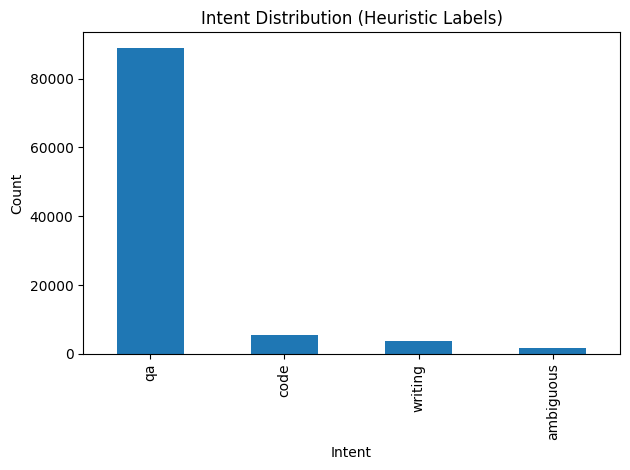

Saved: outputs/figures/rq2_intent_distribution.png


In [108]:
# 3) Intent distribution bar chart (heuristic labels)

rq2_parq = paths["rq2_heuristic_parquet"]
if os.path.exists(rq2_parq):
    rq2 = pd.read_parquet(rq2_parq)
    intent_col = "intent_heuristic" if "intent_heuristic" in rq2.columns else "intent_weak"
    if intent_col not in rq2.columns:
        raise ValueError("Could not find intent_heuristic or intent_weak in rq2 parquet.")
    intent_counts = rq2[intent_col].value_counts(dropna=False)

    plt.figure()
    intent_counts.plot(kind="bar")
    plt.title("Intent Distribution (Heuristic Labels)")
    plt.xlabel("Intent")
    plt.ylabel("Count")
    plt.tight_layout()
    out_path = FIG_DIR / "rq2_intent_distribution.png"
    plt.savefig(out_path, dpi=200)
    plt.show()
    print("Saved:", out_path)
else:
    print("\nIntent distribution chart skipped (rq2 parquet missing).")

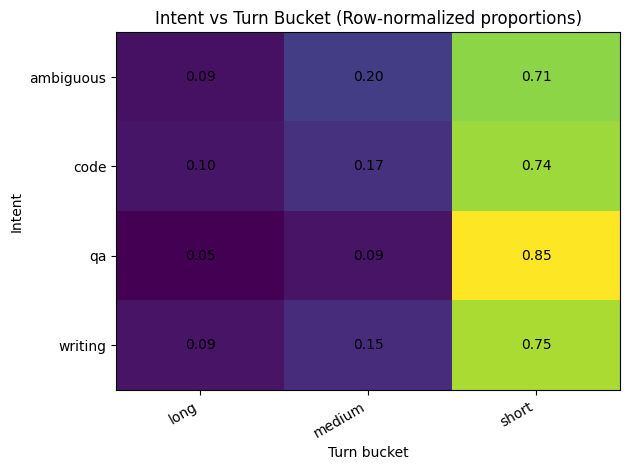

Saved: outputs/figures/intent_vs_turnbucket_heatmap_prop.png


In [111]:
# 4) Intent vs Turn heatmap (from CSV)

heat_csv = "outputs/tables/intent_vs_turnbucket.csv"

hv = pd.read_csv(heat_csv, index_col=0)

plt.figure()
plt.imshow(hv.values, aspect="auto")
plt.xticks(range(hv.shape[1]), hv.columns, rotation=30, ha="right")
plt.yticks(range(hv.shape[0]), hv.index)
plt.title("Intent vs Turn Bucket (Row-normalized proportions)")
plt.xlabel("Turn bucket")
plt.ylabel("Intent")

for i in range(hv.shape[0]):
    for j in range(hv.shape[1]):
        plt.text(j, i, f"{hv.values[i, j]:.2f}", ha="center", va="center")

plt.tight_layout()
out_path = FIG_DIR / "intent_vs_turnbucket_heatmap_prop.png"
plt.savefig(out_path, dpi=200)
plt.show()
print("Saved:", out_path)

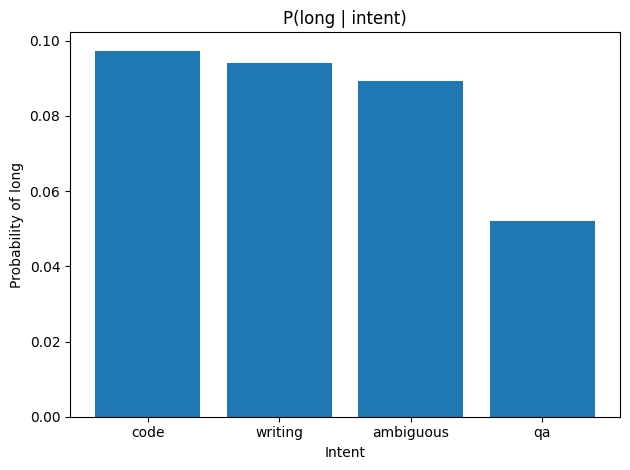

Saved: outputs/figures/p_long_given_intent.png


In [112]:
# 5) P(long | intent) bar chart (from CSV)

pl_csv = paths["p_long_given_intent"]
if os.path.exists(pl_csv):
    pl = pd.read_csv(pl_csv)

    # standardize column names
    if "intent" not in pl.columns:
        pl = pl.rename(columns={pl.columns[0]: "intent"})

    # your file uses 'is_long' as the probability column
    if "p_long" not in pl.columns:
        if "is_long" in pl.columns:
            pl = pl.rename(columns={"is_long": "p_long"})
        else:
            # try other common names
            for c in ["prob_long", "p_long_given_intent", "P_long"]:
                if c in pl.columns:
                    pl = pl.rename(columns={c: "p_long"})
                    break

    if "p_long" not in pl.columns:
        raise ValueError(f"Could not find probability column in {pl_csv}. Columns: {list(pl.columns)}")

    # plot
    plt.figure()
    plt.bar(pl["intent"], pl["p_long"])
    plt.title("P(long | intent)")
    plt.xlabel("Intent")
    plt.ylabel("Probability of long")
    plt.tight_layout()
    out_path = FIG_DIR / "p_long_given_intent.png"
    plt.savefig(out_path, dpi=200)
    plt.show()
    print("Saved:", out_path)
else:
    print("\nP(long|intent) chart skipped (p_long_given_intent.csv missing).")